In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps import Place_net

In [2]:
z_min = -np.pi
z_max = np.pi 
place_num = 1280
neuron_num = int(2 * place_num)
map_num = 4

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=neuron_num, place_num=place_num)
maps = bm.as_numpy(Place_cell.map) # How place cells are mapped to the feature space: map_num * place_num
place_index = bm.as_numpy(Place_cell.place_index) # which sub-group of neurons are seleted as place cells: map_num * place_num
conn_mat = bm.as_numpy(Place_cell.conn_mat) # connection matrix neuron_num * neuron_num

## Global Remapping of place cells 
We first check how many neurons are re-used across differnt environments.

In [3]:
# 将向量转换为集合
set1 = set(place_index[0])
set2 = set(place_index[1])

# 找到两个集合的交集
intersection = set1 & set2

# 计算交集中元素的数量
Overlap_num = len(intersection)

# 将交集转换为数组
Overlap_index = np.array(list(intersection), dtype=int)

# 输出结果
print("Overlap place cell number:", Overlap_num)
print('Overlap rate:', Overlap_num / place_num)
print('Place rate:', place_num / neuron_num)
# print('Overlap index:', Overlap_index)

Overlap place cell number: 642
Overlap rate: 0.5015625
Place rate: 0.5


Next, we check if the preferred location of overlap place cell are totally randomly shuffled across different environments: a hallmark of global remapping

In [4]:
# 找到在place_index中，Overlap_index对应元素的索引
overlap_place_indices = np.zeros([map_num, Overlap_num])
overlap_place_fields = np.zeros([map_num, Overlap_num])
for i in range(map_num):
    indices = [np.where(place_index[i] == idx)[0][0] for idx in Overlap_index]
    overlap_place_indices[i] = indices
    overlap_place_fields[i] = maps[i][indices]

plt.figure()
distance = Place_cell.period_bound(overlap_place_fields[0]-overlap_place_fields[1])
plt.plot(Overlap_index, distance,'.')
plt.xlabel('Overlap index')
plt.ylabel('Field shift')

IndexError: index 0 is out of bounds for axis 0 with size 0

## Embedding Multiple CANNs in one network
First, we check the connection matrix of the network.

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_56517/1197604532.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i].pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='viridis')


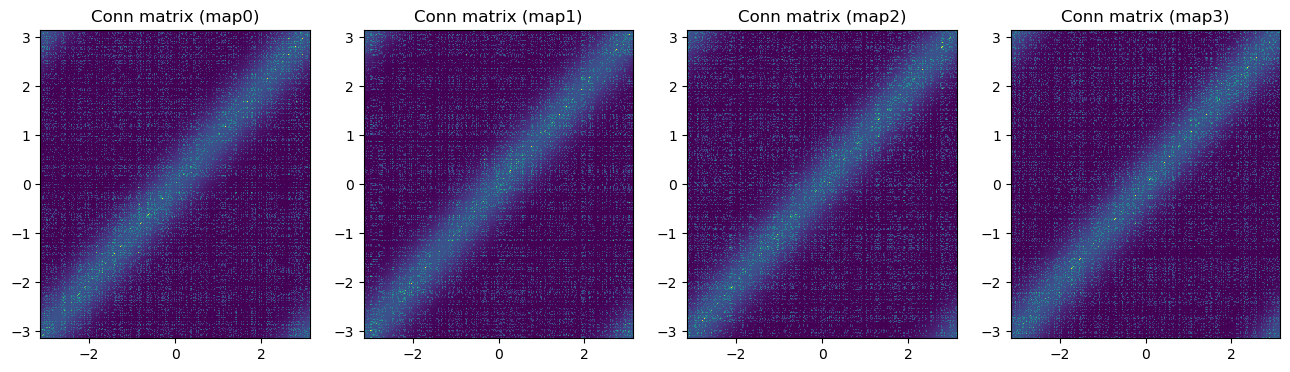

In [5]:
_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for i in range(map_num):
    # 获取排序后的索引
    sorted_indices = np.argsort(maps[i])
    sorted_maps = maps[i, sorted_indices]
    sorted_place_index = place_index[i, sorted_indices]
    sorted_conn_mat = conn_mat[np.ix_(sorted_place_index, sorted_place_index)]

    # 使用 pcolormesh 可视化矩阵
    ax[i].pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='viridis')
    # ax[i].colorbar()  # 添加颜色条
    ax[i].set_title('Conn matrix (map'+str(i)+')')


Next, we check the stationary states of a network embedding two maps in its connectivity.

In [6]:
map_index = 0
def run_net(indices, loc, input_stre):
    Place_cell.step_run(indices, loc=loc, map_index = map_index, input_stre=input_stre)
    u = Place_cell.u
    input = Place_cell.input
    return u, input

total_time = 5000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time)
input_stre = bm.zeros(total_time)
input_stre[start_time:] = 1.
u, input = bm.for_loop(run_net, (indices, loc, input_stre), progress_bar = True)


  0%|          | 0/5000 [00:00<?, ?it/s]

[[  2.5598419   2.5598419   2.5598419 ...   2.5598419   2.5598419
    2.5598419]
 [  5.1010823   5.10904     5.1010823 ...   5.0971036   5.10904
    5.1010823]
 [  7.6159835   7.631826    7.615984  ...   7.6080627   7.631827
    7.615984 ]
 ...
 [256.80325   257.60043   256.80347   ... 256.40488   257.60074
  256.80344  ]
 [256.8031    257.60028   256.8033    ... 256.40472   257.6006
  256.80328  ]
 [256.80353   257.6007    256.80374   ... 256.40515   257.601
  256.8037   ]]
[[  2.5598419   2.5598419   2.5598419 ...   2.5598419   2.5598419
    2.5598419]
 [  5.105061    5.105061    5.0971036 ...   5.1010823   5.0971036
    5.10904  ]
 [  7.623904    7.623905    7.6080627 ...   7.615985    7.6080627
    7.631826 ]
 ...
 [257.2124    258.19476   256.40515   ... 256.80386   256.40515
  257.6008   ]
 [257.21225   258.1946    256.405     ... 256.8037    256.405
  257.60065  ]
 [257.21268   258.19504   256.40543   ... 256.80414   256.40543
  257.60107  ]]
[[  2.5598419   2.5598419   2.559841

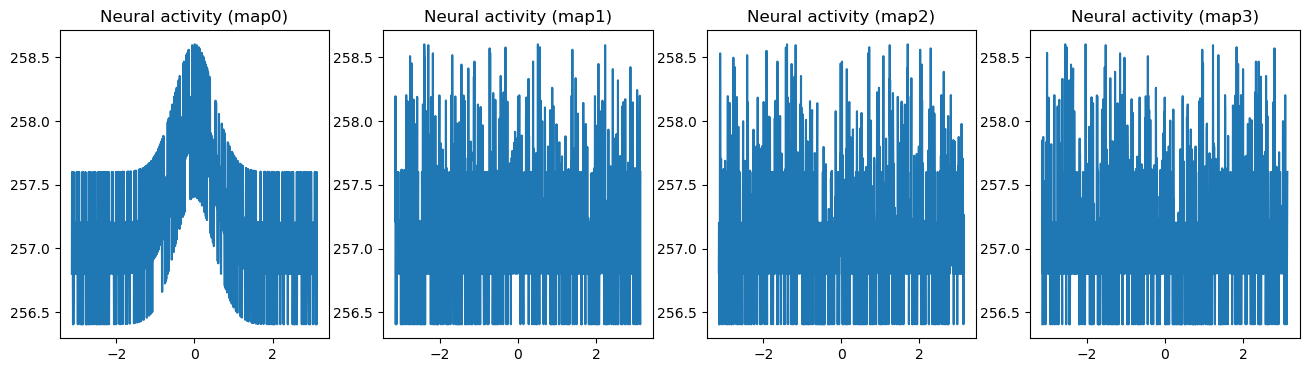

In [9]:
_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(u[:, place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    print(sorted_u_place)
    ax[map_index].plot(sorted_maps, sorted_u_place[-1,:])
    # ax[map_index].set_ylim([0, 5])
    ax[map_index].set_title('Neural activity (map'+str(map_index)+')')